In [110]:
#Different libraries that we need 

import numpy as np # numerical python for operations on arrays, matrix
import pandas as pd # very efficient for handling databases 
import matplotlib.pyplot as plt # for plots 
import glob # for accessing directories (where the data are)
from scipy import stats # scientific python - for special functions and probability densities 
import re # for regular expressions 
from tqdm import tqdm_notebook as tqdm 
import matplotlib.image as mpimg # Importing images for visualization and learning curves comparison (with/without outliers)
import scipy.optimize as opt # curve fitting 
import matplotlib.patches as patches # Active zones
import matplotlib.path as mplPath

# in order to plot inline, Jupyter Notebook only 
%matplotlib notebook 
%matplotlib notebook 

## My functions 

In [14]:
# Find Outliers -- upper and lower limit to 3 std 

def find_outliers(random_data):
    anomalies = []
    # Set upper and lower limit to 3 standard deviation
    random_data_std = np.std(random_data)
    random_data_mean = np.mean(random_data)
    anomaly_cut_off = random_data_std *3
    
    lower_limit  = random_data_mean - anomaly_cut_off 
    upper_limit = random_data_mean + anomaly_cut_off
    # Generate outliers
    for outlier in random_data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    return anomalies

## Importing Data from .csv files

In [15]:
# Import all the .csv files 
trackFiles = []
trackFiles = glob.glob('C:/Users/jamesjun/Desktop/Simone/Csv/CueCsv/Track/*.csv')

shapeFiles = []
shapeFiles = glob.glob('C:/Users/jamesjun/Desktop/Simone/Csv/CueCsv/Shapes/*.csv')

relationsFiles = []
relationsFiles = glob.glob('C:/Users/jamesjun/Desktop/Simone/Csv/CueCsv/Relations/*.csv')

In [16]:
probeFiles = []

# Filtering probe trials 
# if probeFilter = True, probetrials are not used in the future statistics
# if probeFilter = False, probetrials are going to take part in the stats
probeFilter = True 

if probeFilter == True:
    regExpr = re.compile(r'p_Track')
    regExpr2 = re.compile(r'p_shape')
    regExpr3 = re.compile(r'p_relations')
    
    probeFiles = list(filter(lambda i : regExpr.search(i), trackFiles))
    probeShapesFiles = list(filter(lambda i : regExpr2.search(i), shapeFiles))
    probeRelationsFiles = list(filter(lambda i : regExpr3.search(i), relationsFiles))
    
    trackFiles = list(filter(lambda i : not regExpr.search(i), trackFiles))
    shapeFiles = list(filter(lambda i : not regExpr2.search(i), shapeFiles))
    relationsFiles = list(filter(lambda i : not regExpr3.search(i), relationsFiles))
    
    
else : 
    trackFiles = trackFiles 
    shapeFiles = shapeFiles
    relationsFiles = relationsFiles 


In [17]:
# Creating list of tracking Data as list of pandas dataframes 
trackData = []
for i in tqdm(range(0,len(trackFiles))) : 
    trackData.append(pd.read_csv(trackFiles[i], names = ["Time", "X", "Y", "HeadAngle","EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"]))
    """_Track.csv files:
    Columns: T(s), X(m), Y(m), A(deg), R(Hz), D(m), V(m/s), S(m):
    T: camera frame time
    X: x coordinate of the head tip @ grid frame of reference
    Y: y coordinate of the head tip @ grid frame of reference
    A: head orientation
    R: EOD rate
    D: Distance per EOD pulse (=1/sampling_density)
    V: Head speed (m/s, signed)
    S: Distance per Escan (=1/escan_density)"""
    


#Adding landmark name and color in order to create a new dataframe for shapes

landm_name = {'Shape': ['Triangle Lg', 'Triangle Sm',  'Square Lg', 'Square Sm', 'Circle Lg', 'Circle Sm', 'Food']} 
shape_names = pd.DataFrame(data = landm_name)

color_shapes = pd.DataFrame(data = np.linspace(0,1,7), columns= ['Color'])

shapeData = []
for i in tqdm(range(0,len(shapeFiles))) : 
    shapeData.append(pd.read_csv(shapeFiles[i], names = ["X", "Y", "Angle"]))
    shapeData[i] = pd.concat([shape_names,shapeData[i]], axis = 1)
    shapeData[i] = pd.concat([shapeData[i], color_shapes], axis = 1)
    
    """_shapes.csv files:
    Columns: X(m), Y(m), A(deg):
    X(m): x coordinate of the shape center @ grid frame of reference
    Y(m): y coordinate of the shape center @ grid frame of reference
    A(deg): Shape orientation
    Rows: "Triangle Lg", "Triangle Sm", "Square Lg", "Square Sm", "Circle Lg", "Circle Sm", "Food", """
    
    
relationsData = []
for i in tqdm(range(0,len(relationsFiles))) : 
    relationsData.append(pd.read_csv(relationsFiles[i], names = ["CameraFrameTime", "DistFood", "HeadAngleError", 
                                                                 "TriangleLg", "TriangleSm", "SquareLg", "SquareSm", "CircleLg"
                                                                , "CircleSm", "Food"]))

    """_relations.csv files:
       Columns: T(s), D_F(m), A_E(deg), L_"Triangle Lg"(bool), L_"Triangle Sm"(bool), L_"Square Lg"(bool), L_"Square Sm"(bool), L_"Circle Lg"(bool), L_"Circle Sm"(bool), L_"Food"(bool), 
       T: camera frame time
       D_F: distance to the food
       A_E: heading angle error (food_vec - head_vec, 0..90 deg)
       L_"x": Is shape "x" adjacent to the head position? 0:no, 1:yes"""

# Creating list of probe Data as list of pandas dataframes 
probeData = []
for i in tqdm(range(0,len(probeFiles))) : 
    probeData.append(pd.read_csv(probeFiles[i], names = ["Time", "X", "Y", "HeadAngle","EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"]))


probeRelationsData = [] 
for i in tqdm(range(0,len(probeRelationsFiles))) : 
    probeRelationsData.append(pd.read_csv(probeRelationsFiles[i], names = ["CameraFrameTime", "DistFood", "HeadAngleError", 
                                                                 "TriangleLg", "TriangleSm", "SquareLg", "SquareSm", "CircleLg"
                                                                , "CircleSm", "Food"]))
    


In [18]:
#Quick consistency check 
len(trackData) == len(shapeData) ==len(relationsData)

True

## Plotting example trajectory

In [47]:
df_for_sampling_density_analysis = []

for i in tqdm(range(0,len(trackFiles))) :
    df_for_sampling_density_analysis.append(pd.concat([trackData[i]['Time'],
                                                       trackData[i]['X'], trackData[i]['Y'],trackData[i]['DistanceXEODPulse'], relationsData[0]['TriangleLg'],
                                                        relationsData[0]['TriangleSm'], relationsData[0]['SquareLg'], relationsData[0]['SquareSm'],relationsData[0]['CircleLg'],
                                                       relationsData[0]['CircleSm'], relationsData[0]['Food']], axis=1, keys=['Time', 'X', 'Y', 'DistanceXEODPulse','TriangleLg', 'TriangleSm', 'SquareLg', 'SquareSm' ,'CircleLg', 'CircleSm', 'Food']))

<IPython.core.display.Javascript object>


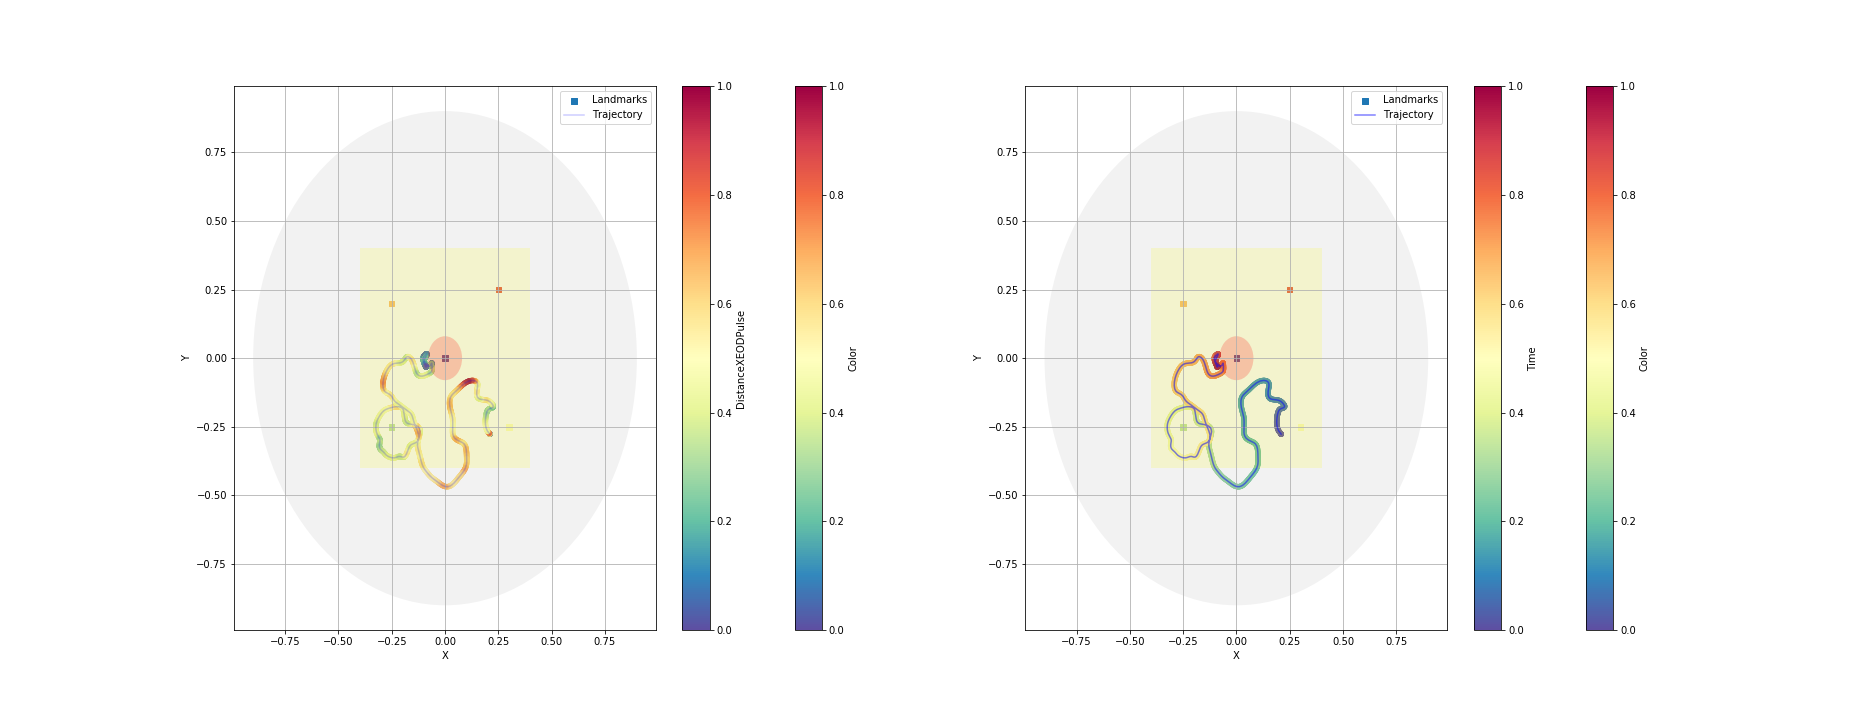

In [108]:
#Select trajectory number (based on number of videos = 199 + 14(probes))
traj_number = 100


fig, (ax1,ax2) = plt.subplots(1,2, figsize = (26,10))

circ = patches.Circle((0, 0), 0.9, alpha=0.10, fc='grey')
square = patches.Rectangle((-0.4,-0.4), 0.8, 0.8, alpha = 0.15, fc = 'yellow')
circ2 = patches.Circle((0, 0), 0.08, alpha=0.20, fc='red')

circ1 = patches.Circle((0, 0), 0.9, alpha=0.10, fc='grey')
square1 = patches.Rectangle((-0.4,-0.4), 0.8, 0.8, alpha = 0.15, fc = 'yellow')
circ12 = patches.Circle((0, 0), 0.08, alpha=0.20, fc='red')


ax1.add_patch(circ)
ax1.add_patch(square)
ax1.add_patch(circ2)

ax2.add_patch(circ1)
ax2.add_patch(square1)
ax2.add_patch(circ12)


plt.grid()
plt.xlim(-1,1)
plt.ylim(-1,1)

shapeData[traj_number].plot.scatter(x = "X", y = 'Y',ax = ax1, marker = 's', s = 30,style = 'o', label = 'Landmarks', c = 'Color', cmap = 'Spectral_r', alpha =1)
df_for_sampling_density_analysis[traj_number].plot.scatter(x = "X", y = "Y", ax = ax1, c = "DistanceXEODPulse",  cmap = 'Spectral_r', alpha = 1)

df_for_sampling_density_analysis[traj_number].plot.line(x = "X", y = 'Y', ax = ax1, style = 'b', alpha = 0.2, grid = True, label = 'Trajectory')

# Setting positions of landmarks and trajectory points 
shapeData[traj_number].plot.scatter(x = "X", y = 'Y',ax = ax2, marker = 's', s = 30, style = 'o', label = 'Landmarks', c = 'Color', cmap = 'Spectral_r', alpha =1)
trackData[traj_number].plot.scatter(x = "X", y = 'Y',ax = ax2,c = 'Time', cmap = 'Spectral_r')

# Adding polygonal chain in order to see the trajectory and get vector length later 
trackData[traj_number].plot.line(x = "X", y = 'Y', ax = ax2, style = 'b', alpha = 0.5, grid = True, label = 'Trajectory')


plt.Axes.autoscale(ax1)
plt.Axes.autoscale(ax2)

## Sampling Density (wrt specific location)

### Creating Dataframe in order to plot Sampling Density with respect to specific location  

In [124]:
early_trials = 17 
dataEarly = []
for i in range(0, early_trials):
    dataEarly.append(df_for_sampling_density_analysis[i].drop(['Time','TriangleLg', 'TriangleSm', 'SquareLg', 'SquareSm', 'CircleLg', 'CircleSm', 'Food'  ], axis =1))

late_trials_start_at = 142
dataLate = [] 
for i in range(late_trials_start_at, len(trackData)):
    dataLate.append(df_for_sampling_density_analysis[i].drop(['Time','TriangleLg', 'TriangleSm', 'SquareLg', 'SquareSm', 'CircleLg', 'CircleSm', 'Food'  ], axis =1))


In [135]:
dfEarly = pd.concat(dataEarly).dropna()
xEarly = dfEarly["X"].values
yEarly = dfEarly["Y"].values
sDEarly = dfEarly["DistanceXEODPulse"].values 

In [346]:
edge_divisions = 200
new_position = np.linspace(-0.5, 0.5, edge_divisions)

In [347]:
grid = np.ones([edge_divisions, edge_divisions])

In [348]:
for j in tqdm(range(0, len(xEarly))):
    for row in range(0, len(new_position)):
        for column in range(0, len(new_position)): 
            if (row < len(new_position)-1) and (column < len(new_position)-1):
                if (xEarly[j] > new_position[row] and xEarly[j] <  new_position[row+1]) and (yEarly[j] > new_position[column] and yEarly[j] <  new_position[column+1]):
                    grid[row][column] = grid[row][column] + sDEarly[j]
                
            #else : 
                #grid[row][column] = grid[row][column] + sDEarly[j] 

In [349]:
grid_early = grid - 1
grid_focus = grid_early[2:198, 2:198]  
np.save("grid200x200Early.txt", grid_focus)

In [350]:
## Normalize data 
grid_focus_normalized = grid_focus / grid_focus.max()

<IPython.core.display.Javascript object>


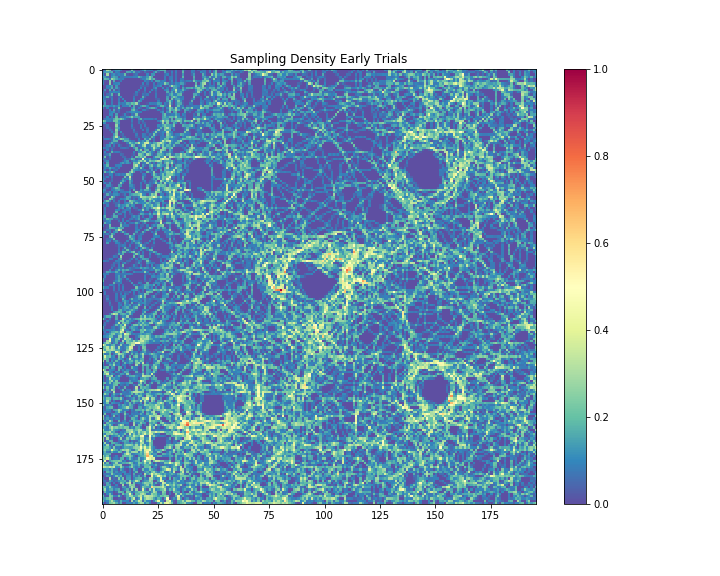

In [351]:
fig, ax = plt.subplots(figsize = (10,8))
plt.imshow(grid_focus_normalized, cmap="Spectral_r", interpolation='nearest')
plt.colorbar()
plt.title("Sampling Density Early Trials")
plt.savefig("Images/Cue/samplingDensityEarly.png")

### Late Trials 

In [352]:
dfLate = pd.concat(dataLate).dropna()
xLate = dfLate["X"].values
yLate = dfLate["Y"].values
sDLate = dfLate["DistanceXEODPulse"].values 

In [353]:
gridLate = np.ones([edge_divisions, edge_divisions])

In [354]:
for j in tqdm(range(0, len(xLate))):
    for row in range(0, len(new_position)):
        for column in range(0, len(new_position)): 
            if (row < len(new_position)-1) and (column < len(new_position)-1):
                if (xLate[j] > new_position[row] and xLate[j] <  new_position[row+1]) and (yLate[j] > new_position[column] and yLate[j] <  new_position[column+1]):
                    gridLate[row][column] = gridLate[row][column] + sDLate[j]
                
            #else : 
                #gridLate[row][column] = gridLate[row][column] + sDLate[j] 

In [355]:
gridLate = gridLate - 1

In [356]:

grid_focus_late = gridLate[2:198, 2:198] 

np.save("grid200x200Late.txt", grid_focus_late)



In [357]:
## Normalize data 
grid_focus_late_normalized = grid_focus_late / grid_focus_late.max()

In [358]:
grid_focus_late.max()

0.06486628000000016

<IPython.core.display.Javascript object>


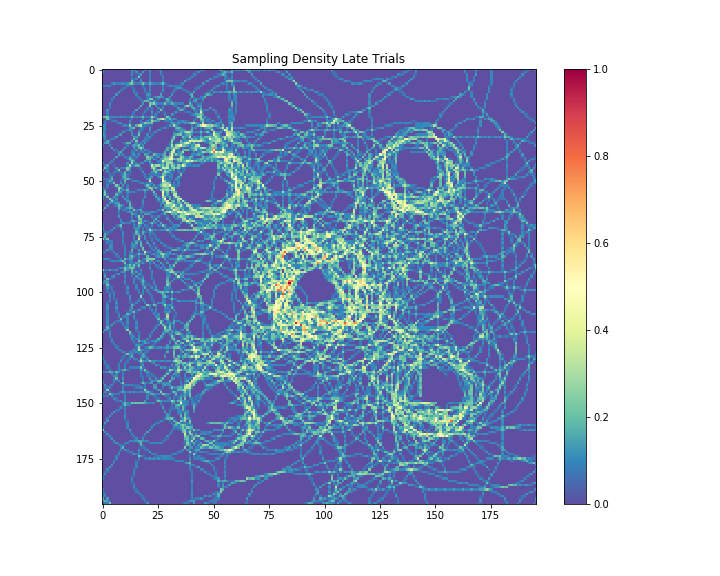

In [359]:
fig, ax = plt.subplots(figsize = (10,8))
plt.imshow(grid_focus_late_normalized, cmap="Spectral_r", interpolation='nearest')
plt.colorbar()
plt.title("Sampling Density Late Trials")
plt.savefig("Images/Cue/samplingDensityLate.png")

## Probe Trials 

### Non-filtered 

In [270]:
df_for_sampling_density_analysis_probe = []

for i in tqdm(range(0,len(probeFiles))) :
    df_for_sampling_density_analysis_probe.append(pd.concat([probeData[i]['Time'],
                                                       probeData[i]['X'], probeData[i]['Y'],probeData[i]['DistanceXEODPulse'], probeRelationsData[0]['TriangleLg'],
                                                        probeRelationsData[0]['TriangleSm'], probeRelationsData[0]['SquareLg'], probeRelationsData[0]['SquareSm'],probeRelationsData[0]['CircleLg'],
                                                       probeRelationsData[0]['CircleSm'], probeRelationsData[0]['Food']], axis=1, keys=['Time', 'X', 'Y', 'DistanceXEODPulse','TriangleLg', 'TriangleSm', 'SquareLg', 'SquareSm' ,'CircleLg', 'CircleSm', 'Food']))

In [271]:
dataProbe = []
for i in range(0, len(probeData)):
    dataProbe.append(df_for_sampling_density_analysis_probe[i].drop(['Time','TriangleLg', 'TriangleSm', 'SquareLg', 'SquareSm', 'CircleLg', 'CircleSm', 'Food'  ], axis =1))


In [360]:
dfProbe = pd.concat(dataProbe).dropna()
xProbe = dfProbe["X"].values
yProbe = dfProbe["Y"].values
sDProbe = dfProbe["DistanceXEODPulse"].values 

In [361]:
gridProbe = np.ones([edge_divisions, edge_divisions])

In [362]:
for j in tqdm(range(0, len(xProbe))):
    for row in range(0, len(new_position)):
        for column in range(0, len(new_position)): 
            if (row < len(new_position)-1) and (column < len(new_position)-1):
                if (xProbe[j] > new_position[row] and xProbe[j] <  new_position[row+1]) and (yProbe[j] > new_position[column] and yProbe[j] <  new_position[column+1]):
                    gridProbe[row][column] = gridProbe[row][column] + sDProbe[j]
                
           # else : 
               # gridProbe[row][column] = gridProbe[row][column] + sDProbe[j] 

In [363]:
gridProbe = gridProbe - 1

In [364]:
grid_focus_probe = gridProbe[2:198, 2:198] 

np.save("grid200x200Probe.txt", grid_focus_probe)

In [365]:
## Normalize data 
grid_focus_probe_normalized = grid_focus_probe / grid_focus_probe.max()

<IPython.core.display.Javascript object>


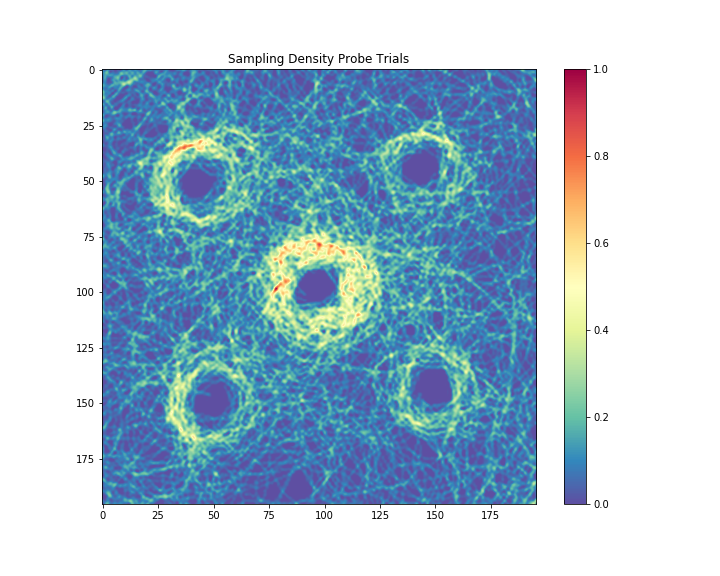

In [370]:
fig, ax = plt.subplots(figsize = (10,8))
plt.imshow(grid_focus_probe_normalized, cmap="Spectral_r", interpolation='bessel')
plt.colorbar()
plt.title("Sampling Density Probe Trials")
plt.savefig("Images/Cue/samplingDensityProbe.png")

### Filtered (first appearance in neighborhood of Triangle Lg) 

In [281]:
# Import Probe Filtered Data 
probeFilteredFiles = []
probeFilteredFiles = glob.glob(r'C:\Users\jamesjun\Desktop\Simone\TrackFiles\TrajectoriesAnalysis\filteredProbeFiles\*.csv')

In [286]:
# Creating list of probe Data as list of pandas dataframes 
probeFilteredData = []
for i in tqdm(range(0,len(probeFilteredFiles))) : 
    probeFilteredData.append(pd.read_csv(probeFilteredFiles[i], names = ["Time", "X", "Y", "HeadAngle","EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"], skiprows=1))
    

In [289]:
df_for_sampling_density_analysis_probe_filtered = []

for i in tqdm(range(0,len(probeFilteredFiles))) :
    df_for_sampling_density_analysis_probe_filtered.append(pd.concat([probeFilteredData[i]['Time'],
                                                       probeFilteredData[i]['X'], probeFilteredData[i]['Y'],probeFilteredData[i]['DistanceXEODPulse']], axis=1, keys=['Time', 'X', 'Y', 'DistanceXEODPulse']))

In [291]:
dataFilteredProbe = []
for i in range(0, len(probeFilteredData)):
    dataFilteredProbe.append(df_for_sampling_density_analysis_probe_filtered[i].drop(['Time'], axis =1))


In [292]:
dfFilteredProbe = pd.concat(dataFilteredProbe).dropna()
xFilteredProbe = dfFilteredProbe["X"].values
yFilteredProbe = dfFilteredProbe["Y"].values
sDFilteredProbe = dfFilteredProbe["DistanceXEODPulse"].values 

In [293]:
gridFilteredProbe = np.ones([edge_divisions, edge_divisions])

In [294]:
for j in tqdm(range(0, len(xFilteredProbe))):
    for row in range(0, len(new_position)):
        for column in range(0, len(new_position)): 
            if (row < len(new_position)-1) and (column < len(new_position)-1):
                if (xFilteredProbe[j] > new_position[row] and xFilteredProbe[j] <  new_position[row+1]) and (yFilteredProbe[j] > new_position[column] and yFilteredProbe[j] <  new_position[column+1]):
                    gridFilteredProbe[row][column] = gridFilteredProbe[row][column] + sDFilteredProbe[j]
                
            else : 
                gridFilteredProbe[row][column] = gridFilteredProbe[row][column] + sDFilteredProbe[j] 

In [295]:
gridFilteredProbe = gridFilteredProbe - 1

In [340]:
grid_focus_probe_filtered = gridFilteredProbe[2:98, 2:98] 

np.save("grid90x90FilteredProbe.txt", grid_focus_probe_filtered)

In [341]:
## Normalize data 
grid_focus_filtered_probe_normalized = grid_focus_probe_filtered / grid_focus_probe_filtered.max()

<IPython.core.display.Javascript object>


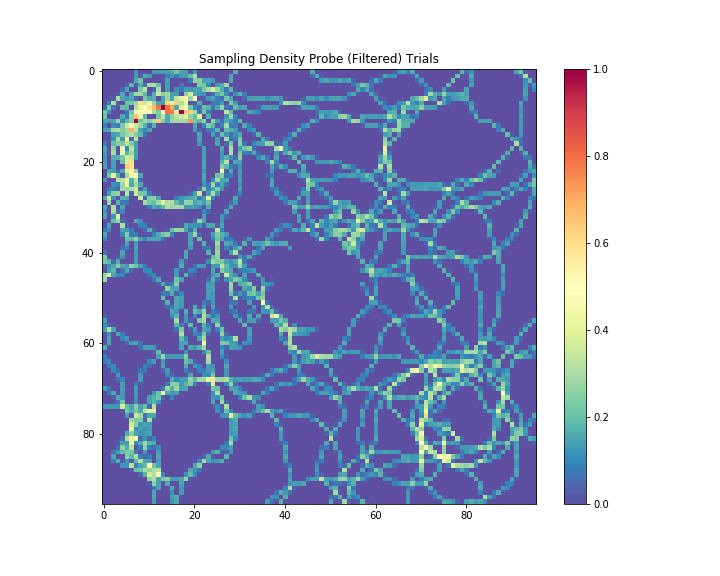

In [342]:
fig, ax = plt.subplots(figsize = (10,8))
plt.imshow(grid_focus_filtered_probe_normalized, cmap="Spectral_r", interpolation='nearest')
plt.colorbar()
plt.title("Sampling Density Probe (Filtered) Trials")
plt.savefig("Images/Cue/samplingDensityFilteredProbe.png")